In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class Plug_in:


    def __init__(self) -> None:
        self.X = None
        self.y = None
        self.classes = None


    @staticmethod
    def gaussian(x : np.ndarray | list, mu : np.ndarray | list, cov : np.ndarray) -> float:
        diff = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)

        return 1 / (np.sqrt((2 * np.pi)**len(x)) * det) * np.exp(-0.5 * np.transpose(diff) * inv * diff)


    def fit(self, X : pd.DataFrame, y : np.ndarray | pd.DataFrame) -> None:
        self.X = X
        self.y = y
        m, n = X.shape

        self.classes = np.unique(self.y)
        self.mu = {}
        self.cov = {c: np.zeros((n, n)) for c in self.classes}
        self.prior_probas = {}

        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()

            for cur in self.X.iloc[self.y[self.y == c].index].values:
                self.cov[c] += np.array([(cur - self.mu[c])]) * np.transpose(np.array([cur - self.mu[c]]))

            self.cov[c] /= m - 1

            self.prior_probas[c] = len(self.X.iloc[self.y[self.y == c].index]) / m


    def predict(self, point : np.ndarray | list) -> int:
        posterior_probas, classes = [], []

        for c in self.classes:
            prior_proba = np.log(self.prior_probas[c])
            mu = self.mu[c]
            cov = self.cov[c]
            posterior_proba = prior_proba + np.sum(np.log(self.gaussian(point, mu, cov)))
            posterior_probas.append(posterior_proba)
            classes.append(c)

        return classes[np.argmax(posterior_probas)]

Все еще будем строить предсказания по формуле:
$$a(x) = \arg \max_{y \in Y} λ_y P_y p_y(x)$$
Так как мы не можем точно узнать значения апрорных вероятностей каждого класса и плотности распределений, посчитаем приближенные оценки $\hat{P_y} \hat{p_y}(x)$. Для $\hat{P_y}$ оставим такой же подход просто:
$$ \hat{P_y} = \frac{|X_l^y|}{|X_l|}$$
Для оценки плотности все так же будем полагать распределение нормальным, но на этот раз построим общую оценку для каждого класса, что по идее должно повысить качество классификации, ведь мы не полагаем признаки независимимы, а считаем оценки для каждого класса. По сути для $\forall y \in Y$ нам требуется оценить величины из многомерного нормального распределения:
$$ N(x, μ, Σ) = \frac{1}{\sqrt{(2 π)^n |Σ|}} e^{-\frac{1}{2} (x-μ)^T Σ^{-1} (x-\mu)} $$
так называемый центр $\mu$ и ковариацинную матрицу $Σ $. Это можно сделать по формулам:
$$\hat{\mu}(x) = \frac{1}{l} \sum_{i=1}^{l} x_i$$
По сути мы просто взяли среднее значение величины объектов, это верно, так как если усреднить это значение по всем выборкам $X$, получим:
$$\mu = E_X \hat{\mu}(x)_X $$
То есть, чем длинее будет выборка, тем точнее мы будем получать оценку.
$$ \hat{Σ} = \frac{1}{l-1} \sum_{i=1}^{l} (x - \hat{\mu}_{y_i})^T(x - \hat{\mu}_{y_i}) $$
Для нее также верно:
$$Σ = E_X \hat{Σ}_X $$
Такое выполняется для оценки с $\frac{1}{l-1}$, потому что если просто усреднить оценка будет смещаться в среднем на $\frac{l}{l-1}$, и мы просто будем получать менее точную оценку с увеличением $l$.
В результате получим классификатор вида:
$$a(x) = \arg \max_{y \in Y} [\ln(λ_y \hat{P_y}) + ln(\hat{p_y}(x))],$$
полагая что $\hat{p_y}(x) = N(x, \hat{\mu}, \hat{Σ})$

In [ ]:
def make_classification_map(best_model : object, x : np.ndarray, y : np.ndarray, data : pd.DataFrame) -> None:
    all_points = []
    for i in np.arange(0, 1, 0.01):
        for j in np.arange(0, 1, 0.01):
          all_points.append([i, j])

    predictions = []
    for i in all_points:
        predictions.append(model.predict(i))


    df = pd.DataFrame(data={'x' : [point[0] for point in all_points], 'y' : [point[1] for point in all_points], 'Label' : predictions})
    sns.scatterplot(data=df, x='x', y='y', hue='Label', palette="magma")
    sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
def generate(mu : float, sigma : float, size=100) -> np.ndarray:
    return np.array(np.random.normal(mu, sigma, size))


def generate_feature(x : np.ndarray, y : np.ndarray):
    return np.concatenate((x, y))


def generate_sample_data(size = 100, option : bool = False) -> pd.DataFrame:
    x = generate_feature(generate(0.2, 0.05, size=size // 2), generate(0.4, 0.05, size=size // 2))
    y = generate_feature(generate(0.4, 0.05, size=size // 2), generate(0.6, 0.05, size=size // 2))
    labels = np.array([0] * (size // 2) + [1] * (size // 2))
    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [ ]:
x, y, labels, data = generate_sample_data(100, option=True)

<Axes: xlabel='x', ylabel='y'>

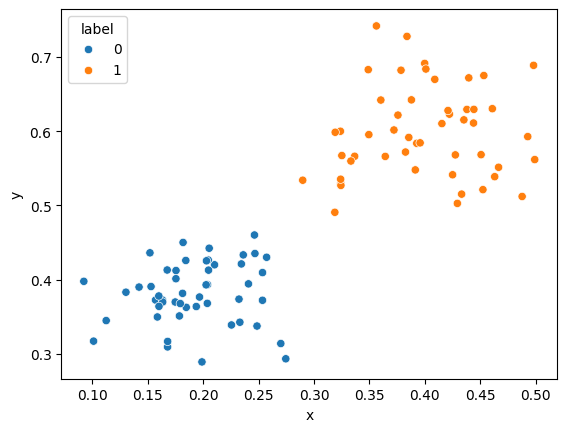

In [ ]:
sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
model = Plug_in()
model.fit(data[['x', 'y']], data.label)

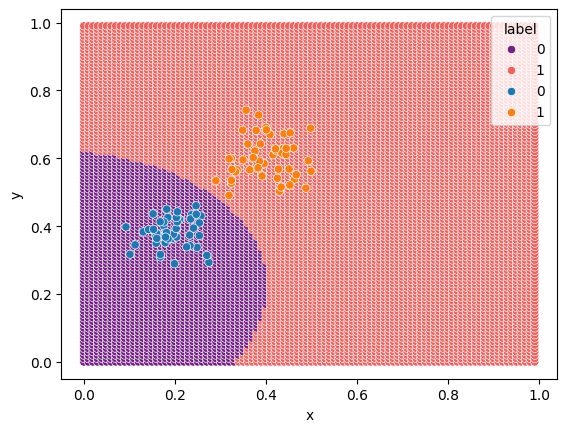

In [ ]:
make_classification_map(model, x, y, data)

Метод работает лучше, чем Наивный Байесовский классификатор, так как строит более точности плотностей. В этом примере мы, кстати, получили разделяющую гиперплоскость в виде параболы.

In [ ]:
def hyperbola(x : float, y : float) -> float:
    return (x - 0.5)**2 / 0.4**2 - (y - 0.5)**2 / 0.4**2 - 0.2**2


def generate_hyperbolic_hyperplate(size = 100, option : bool = False) -> pd.DataFrame:
    x, y, labels = [], [], []
    while len(x) < size:
        sample = np.random.sample((size, 2))
        for point in sample:
            if abs(hyperbola(point[0], point[1])) < 0.2:
              continue
            x.append(point[0])
            y.append(point[1])
            if hyperbola(point[0], point[1]) < 0:
              labels.append(0)
            else:
              labels.append(1)
            #print(len(x))

    x = x[:size]
    y = y[:size]
    labels = labels[:size]

    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [ ]:
x, y, labels, data = generate_hyperbolic_hyperplate(400, option=True)

<Axes: xlabel='x', ylabel='y'>

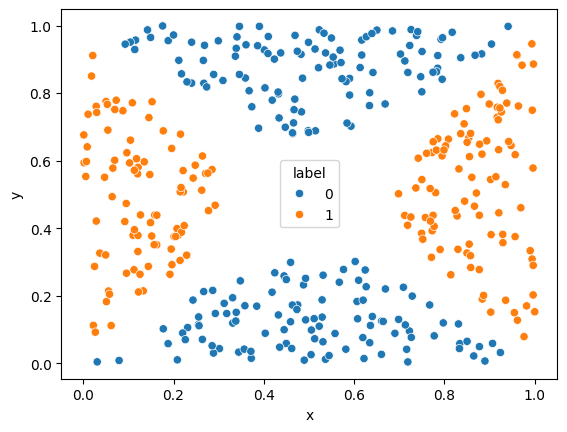

In [ ]:
sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
model.fit(data[['x', 'y']], data.label)

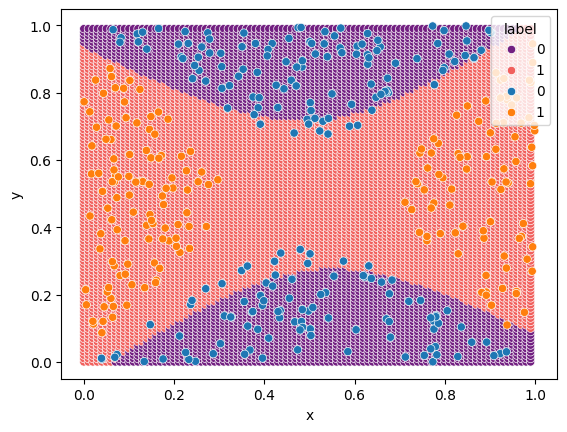

In [ ]:
make_classification_map(model, x, y, data)

А тут получили гиперболу

In [ ]:
def ellipse(x : float, y : float) -> float:
    return (x - 0.5)**2 + (y - 0.5)**2 - 0.2**2


def generate_ellipse_hyperplate(size = 100, option : bool = False) -> pd.DataFrame:
    x, y, labels = [], [], []
    while len(x) < size:
        sample = np.random.sample((size, 2))
        for point in sample:
            if abs(ellipse(point[0], point[1])) < 0.1 and ellipse(point[0], point[1]) > 0:
              continue
            x.append(point[0])
            y.append(point[1])
            if ellipse(point[0], point[1]) < 0:
              labels.append(0)
            else:
              labels.append(1)
            #print(len(x))

    x = x[:size]
    y = y[:size]
    labels = labels[:size]

    if option:
        return x, y, labels, pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})
    return pd.DataFrame(data={'x' : x, 'y' : y, 'label' : labels})

In [ ]:
x, y, labels, data = generate_ellipse_hyperplate(400, option=True)

<Axes: xlabel='x', ylabel='y'>

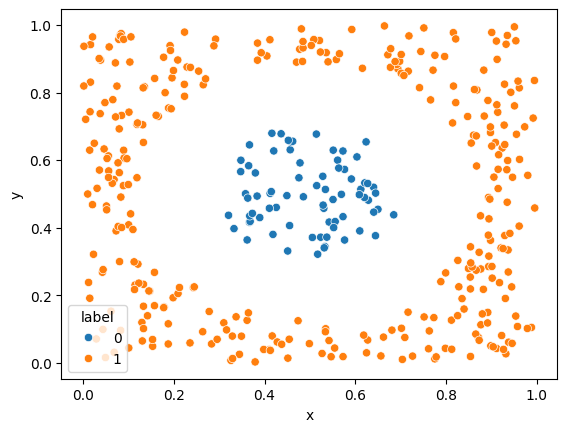

In [ ]:
sns.scatterplot(data=data, x='x', y='y', hue='label')

In [ ]:
model.fit(data[['x', 'y']], data.label)

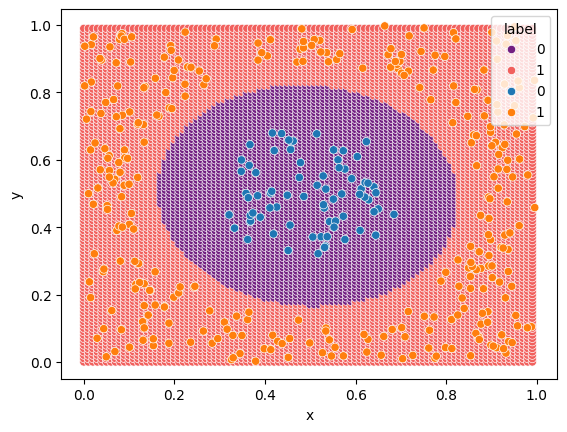

In [ ]:
make_classification_map(model, x, y, data)

А тут эллипс

В целом, Plug-in возможно работает лучше, ведь разделяющие гиперплоскости проходят точнее, но у этого алгоритма есть множество проблем:


1.   Если данные не распределены нормально или хотя бы близко к нормальному, то качество классификации будет плохим
2.   Алгоритм очень чувствителен в выбросам, если хотя бы 1 точка будет аномальной, гиперплоскость сдвинется ближе к этой точке и нам конец...
3.   Так как для расчета $N(x, \mu, Σ)$ мы считаем $Σ^{-1}$ и $|Σ|$, может случится, что матрица окажется вырожденной, или $|Σ| = 0$ или плохо обусловленной, когда малейшее изменение значений $Σ$ ведет к большому изменению значений $Σ^{-1}$. В первом случае, нам придется удалить часть точек, что, как минимум, не гарантирует избавление от вырожденности, а, как максимум, качество классификации будет сомнительным. Во втором случае нам лучше использовать другой алгоритм классификации, ведь мы построим гиперплоскость, которая может и будет правдива для наших данных, но обобщающая способность алгоритма будет малой.

